In [1291]:
import numpy as np 
from timeit import timeit
import pandas as pd 
import matplotlib.pyplot as plt 
from scipy.stats import linregress
import scipy

from sympy import Symbol, Matrix, re
from sympy.solvers import solve
import easygdf

import scipy.io as scio
from PIL import ImageOps
from PIL import Image

### Convert UV image to grayscale BMP and trim away corners

In [12]:
path = "/home/ocamacho/FACET_model/FACET_model/FACET_cathode_dist/cathode_dist_2_centered_1.bmp"
dist= Image.open(path)
dist = ImageOps.grayscale(dist)
dist
dist.save("/home/ocamacho/FACET_model/FACET_model/FACET_cathode_dist/UV_BW.bmp")

In [13]:
X = np.array(dist)
for i in range(776):
    for j in range(776) :
        if ((i - 776/2)**2 + (j - 776/2)**2 > (776/2)**2):
            X[i][j] =0;
            

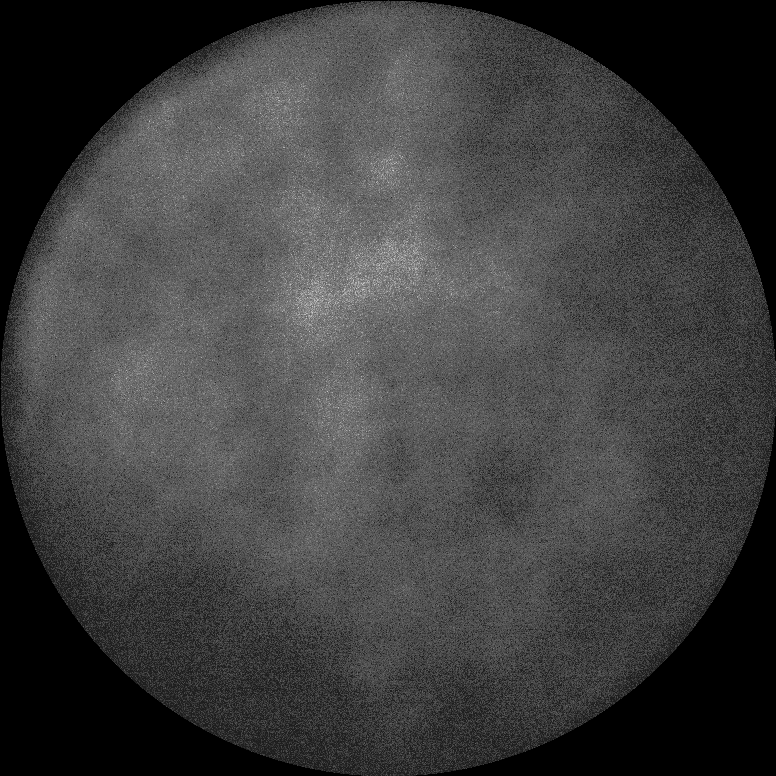

In [14]:
Y = Image.fromarray(X)
Y

In [15]:
Y.save( "/home/ocamacho/FACET_model/FACET_model/FACET_cathode_dist/UV_BW.BMP")

### This goes into the input deck now. We run the simulation with all quads off and the gun and L0AF/L0BF on. We use this accelerated beam at ~8m as input to then run another simulation with RF fields and quads off, in which we simply allow the beam to drift for a few meters after acceleration. We will use these as candidate positions to place the RTFB lattice.

### Now that we've run the simulation externally, we load in the resevoir of potential start-screens (56 in our case, from avgz = 8.085 to avgz = 10.535). Full space charge, 30k macroparticles for the first pass

In [1358]:

screen_dump_path = "/home/ocamacho/FACET_model/FACET_model/bitmap_test_8.2.gdf";
screen_dump = easygdf.load_screens_touts(screen_dump_path);
screens = screen_dump.get('touts');

In [1359]:
screen = screens[40] #Pick a place to start, I suppose

In [1360]:

print("Placing first skew quad near z = ", np.mean(screen.get('z')) )

Placing first skew quad near z =  9.866493527388908


In [1361]:
#Here we fix the drift lengths
avg_z = np.mean(screen.get('z'))
d0, d1, d2 = 0.045, 1.55, 1.65
L = 0.108;
fixed_quads = np.array([7.9495043, 8.3510173, 11.039235, 11.4292015])
D = np.array([avg_z + d0, avg_z + d0 + d1, avg_z + d0 + d1 + d2])
print(14- (    np.mean(np.mean(screen.get('z'))) + d0 + d1 + d2 + 0.05  )   )

0.8385064726110905


In [1362]:
#We make sure this choice won't overlap with any of the quads whose positions are already fixed on the beamline

QFL1_pos = np.mean(screen.get('z'))
valid = 1;
for i in range(len(fixed_quads)):
    for j in range(len(D)):
        if(np.abs(fixed_quads[i] - (QFL1_pos+ D[j])) < L) :
            valid = 0;
            print("Error: Overlap between flattener at ", QFL1_pos, "+", D[j]," and fixed quad at ", fixed_quads[i]);
if valid == 1:
    print("These quad positions are valid, carry on")

These quad positions are valid, carry on


In [1363]:
init_guess(screen, d0, d1, d2)


(array([-0.5759607 ,  0.83175659, -1.60733747]),
 306.2177599414876,
 [37.29191489341769, 11419.446642590965])

In [1364]:
name = str(np.mean(screen.get('z')))[0:5] + "m_screen.gdf"
screen_path = "/home/ocamacho/FACET_model/FACET_model/" + name

screen_path

'/home/ocamacho/FACET_model/FACET_model/9.866m_screen.gdf'

In [1365]:
Q_tot = 2.0e-9 #Coulombs
n_simu = len(screen.get('x'))
qe = 1.6022e-19 #Coulombs
miden = np.ones(n_simu)
easygdf.save_screens_touts(f = screen_path, touts = [screen]) 

In [1366]:
screen_path

'/home/ocamacho/FACET_model/FACET_model/9.866m_screen.gdf'

#### We will use this screen as the input for the skew quad triplet

#### Get an initial guess for the quad strengths by optimizing the thin-lens analytic objective function 

## We'll need a few functions

In [1367]:
%run FACET_Flattening_Procedures.ipynb

Procedures are now available


#### Flattening with thin lens model (deprecated)

In [1368]:
#RTFB_0(screen, d0, d1, d2) #Test

In [1369]:
#print(d0, d1, d2)

In [1370]:
#RTFB_0(screen, d0, d1, d2)

In [1371]:
#emit_ratio_analytic = lambda Q: 1/RTFB_1(screen, Q[0], Q[1], Q[2], d0, d1, d2)[1]

In [1372]:
#Q = RTFB_0(screen, d0, d1, d2)[0]

In [1373]:
#RTFB_1(screen,Q[0], Q[1], Q[2], d0, d1, d2)

In [1374]:
#opt_thin_lens = scipy.optimize.minimize(emit_ratio_analytic, x0 = Q, method = 'Nelder-Mead', options = {'xatol': 0.0001, 'fatol': 0.00010})
#opt_thin_lens

In [1375]:
#test_quads = opt_thin_lens.get('x')

### Next we get a better estimate using the thick-lens model

In [1376]:
%run FACET_Flattening_Procedures.ipynb

Procedures are now available


In [1377]:
### We are focused on minimizing the ratio epsy/epsx

emit_ratio_thick = lambda test_quads: RTFB_thick_transform(screen, test_quads[0], test_quads[1], test_quads[2], d0, d1, d2)[1]

In [1378]:
test_quads = init_guess(screen, d0, d1, d2)[0] 

In [1379]:
RTFB_thick_transform(screen, test_quads[0], test_quads[1], test_quads[2], d0, d1, d2)

([-0.5759607037894037, 0.8317565909806696, -1.6073374672931853],
 306.2177599414876,
 [37.29191489341769, 11419.446642590965])

In [1380]:
test_quads

array([-0.5759607 ,  0.83175659, -1.60733747])

In [1381]:
RTFB_thick(test_quads[0], test_quads[1], test_quads[2], d0, d1, d2)

array([[1.55277529, 0.40157687, 0.39801532, 0.01090435],
       [3.63331379, 1.56109921, 2.00074781, 0.14279695],
       [0.39801532, 0.01090435, 1.55277529, 0.40157687],
       [2.00074781, 0.14279695, 3.63331379, 1.56109921]])

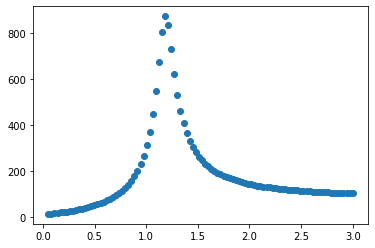

In [1382]:
### Do a crude optimization "by hand"

D = np.linspace(0.05, 3.0, 100)
R = np.array([emit_ratio_thick(delta*test_quads) for delta in D])
plt.scatter(D,R)

In [1120]:

ind = np.where(R == np.max(R))
delta = D[ind]
R[ind]

array([44.08343833])

In [1344]:
test_quads

array([-0.5759607 ,  0.83175659, -1.60733747])

In [1122]:
facs = np.array([1,1,1]);

test_quads = delta*test_quads
test_quads


array([ 1.42374825, -2.54823938,  4.83549915])

In [1308]:
def inv_emit_ratio_thick(Q):
    return 1/emit_ratio_thick(Q)

In [1383]:
opt_thick_lens = scipy.optimize.minimize(inv_emit_ratio_thick, x0 = test_quads, method = 'Nelder-Mead', options = {'xatol': 0.0010, 'fatol': 0.0010}, 
                       bounds = [(-0.9, 0.0), (0.0005, 1.0), (-1.0, 0.0)])
print(opt_thick_lens)

#test_quads = opt_thick_lens.get('x')

 final_simplex: (array([[-9.e-01,  5.e-04, -1.e+00],
       [-9.e-01,  5.e-04, -1.e+00],
       [-9.e-01,  5.e-04, -1.e+00],
       [-9.e-01,  5.e-04, -1.e+00]]), array([0.00526805, 0.00526805, 0.00526805, 0.00526805]))
           fun: 0.0052680459504578355
       message: 'Optimization terminated successfully.'
          nfev: 21
           nit: 11
        status: 0
       success: True
             x: array([-9.e-01,  5.e-04, -1.e+00])


/home/ocamacho/.virtualenvs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: OptimizeWarning: Initial guess is not within the specified bounds
  


In [1384]:
#test_quads = opt_thick_lens.get('x')
def inv_emit_ratio_drift(Q):
    
    return 1/emit_ratio_drift(Q)


emit_ratio_drift = lambda drifts: RTFB_thick_transform(screen, test_quads[0], test_quads[1], test_quads[2], drifts[0], drifts[1], drifts[2])[1]

dist_opt = scipy.optimize.minimize(emit_ratio_drift, x0 = [d0, d1, d2], method = 'Nelder-Mead', options = {'xatol': 0.001, 'fatol': 0.0010}, bounds = [(0,0.10), (0.75, 2.0), (1.0, 3.2)])
print(dist_opt)



 final_simplex: (array([[0.  , 0.75, 3.2 ],
       [0.  , 0.75, 3.2 ],
       [0.  , 0.75, 3.2 ],
       [0.  , 0.75, 3.2 ]]), array([141.31683436, 141.31683436, 141.31683436, 141.31683436]))
           fun: 141.31683436202465
       message: 'Optimization terminated successfully.'
          nfev: 27
           nit: 15
        status: 0
       success: True
             x: array([0.  , 0.75, 3.2 ])


In [1347]:
d0, d1, d2 = dist_opt.get('x')[0], dist_opt.get('x')[1], dist_opt.get('x')[2]

In [1385]:
start_path

'/home/ocamacho/FACET_model/FACET_model/9.866m_dump.gdf'

### Now use this as a starting point for the optimization through the space-charge simulation

In [1386]:
#Check the initial position of the screen we're using
screen_avg_z = np.mean(screen.get('z'));

#Fix the initial drift
d0;
#Load in the location at which the first quad is located
quadzstartFL1 = screen_avg_z + d0;
#Fix start position
replace_line("/home/ocamacho/FACET_model/FACET_model/simu_scan.mr", 197, "quadzStartFL1 "+ str(quadzstartFL1) + " #the updated value of quadzStartFL1 \n");

#Position of the new start path
start_path = "/home/ocamacho/FACET_model/FACET_model/" + str(np.round(screen_avg_z,3))+"m_dump.gdf"
#Change the loadin line in the .mr file to True
replace_line("/home/ocamacho/FACET_model/FACET_model/simu_scan.mr", 16, "loadin 1 #If true, we load in an external beam distribution \n");
#Change the loadin path to start_path
replace_line("/home/ocamacho/FACET_model/FACET_model/simu.in",6, " if(loadin == 1) setfile(\"beam\", \""  + screen_path + "\"); \n")

Line changed.
The line is now quadzStartFL1 9.911493527388908 #the updated value of quadzStartFL1 


Line changed.
The line is now loadin 1 #If true, we load in an external beam distribution 


Line changed.
The line is now  if(loadin == 1) setfile("beam", "/home/ocamacho/FACET_model/FACET_model/9.866m_screen.gdf"); 




In [1387]:
#Fix the quad values

replace_line("/home/ocamacho/FACET_model/FACET_model/simu.in",317, "q1 = fac1*(" + str(test_quads[0]) + "); # \n")

replace_line("/home/ocamacho/FACET_model/FACET_model/simu.in",318, "q2 = fac2*(" + str(test_quads[1]) + "); # \n")

replace_line("/home/ocamacho/FACET_model/FACET_model/simu.in",319, "q3 = fac3*(" + str(test_quads[2]) + "); #   \n")
#=

Line changed.
The line is now q1 = fac1*(-0.5759607037894037); # 


Line changed.
The line is now q2 = fac2*(0.8317565909806696); # 


Line changed.
The line is now q3 = fac3*(-1.6073374672931853); #   




In [1388]:
#Fix the drifts to match the values used in the analytic estimate

params = ['d0', 'd1', 'd2']
param_vals = [d0,d1, d2]
for i in range(len(params)):
    change_param('/home/ocamacho//FACET_model/FACET_model/simu_scan.mr',params[i], param_vals[i]);

The line is currently d0 0.1 # updated value of d0



Line changed.
The line is now d0 0.045 # updated value of d0




The line is currently d1 2.0 # updated value of d1



Line changed.
The line is now d1 1.55 # updated value of d1




The line is currently d2 1.0 # updated value of d2



Line changed.
The line is now d2 1.65 # updated value of d2






In [1389]:

def emit_simu(params, param_vals):
        
    for i in range(len(params)):
        change_param('/home/ocamacho//FACET_model/FACET_model/simu_scan.mr',params[i], param_vals[i]);
        
    
    
    #Run the simulation and obtain the figures of merit
    #This is the most CPU intensive part of the function
    ! mr -v -o '/home/ocamacho//FACET_model/FACET_model/opt_run.gdf' '/home/ocamacho/FACET_model/FACET_model/simu_scan.mr' gpt -j 127 '/home/ocamacho/FACET_model/FACET_model/simu.in'
    ! gdfa -o '/home/ocamacho/FACET_model/FACET_model/avgs_opt_run.gdf'  '/home/ocamacho/FACET_model/FACET_model/opt_run.gdf' time avgz avgx avgy stdz stdx stdy avgBz avgBx avgBy stdBx stdBy nemirrms nemixrms nemiyrms nemizrms avgG stdG numpar 

    
    
    #Read in the gdfa putput
    avgs = easygdf.load('/home/ocamacho/FACET_model/FACET_model/avgs_opt_run.gdf').get('blocks')
    #Compare emittances
    nemixrms = avgs[13].get('value')[-1]
    
    nemiyrms = avgs[14].get('value')[-1]
    
    ratio = nemiyrms/nemixrms #, nemiyrms/nemixrms)
    
    return nemixrms, nemiyrms, ratio
    

In [1390]:
test_quads

array([-0.5759607 ,  0.83175659, -1.60733747])

#### Do an initial test...



In [1396]:
results = [emit_simu(['fac1', 'fac2', 'fac3'], np.array([1,1,1]) )]


The line is currently fac1 0.06666666666666667 # updated value of fac1



Line changed.
The line is now fac1 -1 # updated value of fac1




The line is currently fac2 0.06666666666666667 # updated value of fac2



Line changed.
The line is now fac2 -1 # updated value of fac2




The line is currently fac3 0.06666666666666667 # updated value of fac3



Line changed.
The line is now fac3 -1 # updated value of fac3




Fixed 'acc': 5
Fixed 'spacec': 1
Fixed 'nscreens': 25
Fixed 'zScreen1': 0.942
Fixed 'zScreen2': 9.1047
Fixed 'zScreen3': 9.7802
Fixed 'zstart': 9.25
Fixed 'zend': 13
Fixed 'optMode': 0
Fixed 'loadin': 1
Fixed 'nps': 7000
Fixed 'Qtot': 2
Fixed 'tlen': 2e-12
Fixed 'beamDiam': 0.0045
Fixed 'themit': 3.27e-06
Fixed 'gunPhase': -78
Fixed 'magSolStart': -0.2
Fixed 'magSolFac': 0.2457
Fixed 'solStart': 0
Fixed 'solFac': 0.2457
Fixed 'eps': 1
Fixed 'quadzStart1': 0.361
Fixed 'quadLength1': 0.21
Fixed 'quadBore1': 0.0254
Fixed 'quadGrad1': 0.00714
Fixed 'quadzStart2': 0.361
Fixed 'q

##### Print out ($\epsilon_{x}, \epsilon_{y}, \frac{\epsilon_{y}}{\epsilon_{x}}$)

In [1398]:
results
#print(result)
#print(1/result[-1])


[(6.33764682542615e-05, 0.00010311706630050321, 1.6270560531521812)]

In [ ]:
#! gdfa -o '/home/ocamacho/FACET_model/FACET_model/avgs_opt_run.gdf'  '/home/ocamacho/FACET_model/FACET_model/opt_run.gdf' time avgz avgx avgy stdz stdx stdy avgBz avgBx avgBy stdBx stdBy nemirrms nemixrms nemiyrms nemizrms avgG stdG numpar 


In [ ]:
#! mr -v -o '/home/ocamacho//FACET_model/FACET_model/100k_run.gdf' '/home/ocamacho/FACET_model/FACET_model/simu_scan.mr' gpt -j 127 '/home/ocamacho/FACET_model/FACET_model/simu.in'
#! gdfa -o '/home/ocamacho/FACET_model/FACET_model/avgs_100k_run.gdf'  '/home/ocamacho/FACET_model/FACET_model/100k_run.gdf' time avgz avgx avgy stdz stdx stdy avgBz avgBx avgBy stdBx stdBy nemirrms nemixrms nemiyrms nemizrms avgG stdG numpar 

In [ ]:
#params = [];
#param_vals = [];
#output = emit_simu(params, param_vals);


In [805]:
def emit_ratio_simu(param_vals):
    return emit_simu(params, param_vals)[2]



In [ ]:
#Alternatively, if you want to tune the quads independently...

def emit_ratio_simu_0(Q0):
    param_vals[0]= Q0;
    return emit_simu(params, param_vals)[2]

def emit_ratio_simu_1(Q1):
    param_vals[1] = Q1;
    return emit_simu(params, param_vals)[2]

def emit_ratio_simu_2(param_vals):
    param_vals[2] = Q2;
    return emit_simu(params, param_vals)[2]

In [ ]:
d0 + d1 + d2 + screen_avg_z

### Now we run an optimizer, tuning the quad values

In [808]:
#3D Optimization

params = np.array(['fac1', 'fac2', 'fac3'])
param_vals = -np.array([1, 1, 1 ])/3.87; #np.array([0.03900545, 0.01935176, 0.06951172])
#Q = np.array(Q)/1.9;

QuadResult = scipy.optimize.minimize(emit_ratio_simu, x0 = param_vals, method = 'Nelder-Mead', options = {'xatol': 2.5e-4, 'fatol': 0.0001, 'maxiter': 50}, 
                                     bounds = [(0.0, 1.0), (0.0, 1.0), (0.0, 1.0)],)
QuadResult


The line is currently fac1 0.0 # updated value of fac1



Line changed.
The line is now fac1 0.0 # updated value of fac1




The line is currently fac2 1.0 # updated value of fac2



Line changed.
The line is now fac2 0.0 # updated value of fac2




The line is currently fac3 0.0 # updated value of fac3



Line changed.
The line is now fac3 0.0 # updated value of fac3




Fixed 'acc': 5
Fixed 'spacec': 1
Fixed 'nscreens': 25
Fixed 'zScreen1': 0.942
Fixed 'zScreen2': 9.1047
Fixed 'zScreen3': 9.7802
Fixed 'zstart': 9.25
Fixed 'zend': 13
Fixed 'optMode': 0
Fixed 'loadin': 1
Fixed 'nps': 10000
Fixed 'Qtot': 2
Fixed 'tlen': 2e-12
Fixed 'beamDiam': 0.0045
Fixed 'themit': 3.27e-06
Fixed 'gunPhase': -78
Fixed 'magSolStart': -0.2
Fixed 'magSolFac': 0.2457
Fixed 'solStart': 0
Fixed 'solFac': 0.2457
Fixed 'eps': 1
Fixed 'quadzStart1': 0.361
Fixed 'quadLength1': 0.21
Fixed 'quadBore1': 0.0254
Fixed 'quadGrad1': 0.00714
Fixed 'quadzStart2': 0.361
Fixed 'quadLength2': 0.21
Fixed 'quadBore2': 0.0254


/home/ocamacho/.virtualenvs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: OptimizeWarning: Initial guess is not within the specified bounds
  


gpt: Tout at 3.085468e-08 ignored
The line is currently fac1 0.0 # updated value of fac1



Line changed.
The line is now fac1 0.00025 # updated value of fac1




The line is currently fac2 0.0 # updated value of fac2



Line changed.
The line is now fac2 0.0 # updated value of fac2




The line is currently fac3 0.0 # updated value of fac3



Line changed.
The line is now fac3 0.0 # updated value of fac3




Fixed 'acc': 5
Fixed 'spacec': 1
Fixed 'nscreens': 25
Fixed 'zScreen1': 0.942
Fixed 'zScreen2': 9.1047
Fixed 'zScreen3': 9.7802
Fixed 'zstart': 9.25
Fixed 'zend': 13
Fixed 'optMode': 0
Fixed 'loadin': 1
Fixed 'nps': 10000
Fixed 'Qtot': 2
Fixed 'tlen': 2e-12
Fixed 'beamDiam': 0.0045
Fixed 'themit': 3.27e-06
Fixed 'gunPhase': -78
Fixed 'magSolStart': -0.2
Fixed 'magSolFac': 0.2457
Fixed 'solStart': 0
Fixed 'solFac': 0.2457
Fixed 'eps': 1
Fixed 'quadzStart1': 0.361
Fixed 'quadLength1': 0.21
Fixed 'quadBore1': 0.0254
Fixed 'quadGrad1': 0.00714
Fixed 'quadzStart2': 0.361
Fixed 'quadLen

 final_simplex: (array([[0.11105849, 0.        , 0.0152021 ],
       [0.11090441, 0.        , 0.01518229],
       [0.11115474, 0.        , 0.01520193],
       [0.11083634, 0.        , 0.01516267]]), array([0.03796191, 0.03796209, 0.03796672, 0.03796752]))
           fun: 0.03796191015484532
       message: 'Optimization terminated successfully.'
          nfev: 75
           nit: 40
        status: 0
       success: True
             x: array([0.11105849, 0.        , 0.0152021 ])

In [809]:
1/QuadResult.get('fun')

26.34219394969944

In [ ]:
np.array([1,1.0,1.0])/11.3

In [ ]:
#1D Optimization
params = np.array(['fac1', 'fac2', 'fac3'])
param_vals = np.array([1.0,1.0,1.0])/11.3
def emit_ratio_simu_0(Q0):
    return 1/inv_emit_ratio_simu_0[Q0, test_quads[1], test_quads[2]]
%time
Quad0Result = scipy.optimize.minimize(emit_ratio_simu_0, x0 = F0[0], method = 'Nelder-Mead', options = {'xatol': 0.01, 'fatol': 0.01, 'maxiter': 10}, 
                                      bounds = [(0.0, 1.5)])
Quad0Result

In [ ]:
#1D Optimization
params = ['fac1', 'fac2', 'fac3']
param_vals = [1.0, 1.0, 1.0]
F0 = np.array(param_vals)/2;

%time
Quad1Result = scipy.optimize.minimize(emit_ratio_simu_1, x0 = F0[1], method = 'Nelder-Mead', options = {'xatol': 2.5e-5, 'fatol': 0.000005}, 
                                     bounds = [(2.0, 0.0)])
Quad1Result

In [ ]:
#1D Optimization
params = ['fac1', 'fac2', 'fac3']
param_vals = [1.0, 1.0, 1.0]
F0 = np.array(param_vals)/2;

%time
Quad2Result = scipy.optimize.minimize(emit_ratio_simu_2, x0 = F0[2], method = 'Nelder-Mead', options = {'xatol': 2.5e-5, 'fatol': 0.000005}, 
                                     bounds = [(-2.0, 0.0)])
Quad2Result

In [ ]:
### For a ratio of ~200:

fac1 = 1.80653151;
fac2 = 0.96201232
fac3 = 0.37663937;

#init_vals 

q1 = fac1*(-0.70686675); 
#d1 = 1.5 + dd1;

q2 = (fac2)*0.63699416; 

#d2 = 2.0 + dd2;

q3 = (fac3)*(-0.59803042 ); 
avgG = 136.6;
c = 2.99792458e8;
quadL = 0.108
#d4 = 0.30;

#q4 = fac4;

In [ ]:
data = easygdf.load('/home/ocamacho/FACET_model/FACET_model/opt_run.gdf').get('blocks')
avgs = easygdf.load('/home/ocamacho/FACET_model/FACET_model/avgs_opt_run.gdf').get('blocks')

In [ ]:
#grads = np.array([avgG*0.511*q1*(1e6)/(c*quadL), avgG*0.511*q2*(1e6)/(c*quadL), avgG*0.511*q3*(1e6)/(c*quadL)])

In [ ]:
[avgz, nemirrms, nemixrms, nemiyrms] = [avgs[1].get('value'),avgs[12].get('value'), avgs[13].get('value'), avgs[14].get('value')]

In [ ]:
avgs[16].get('value')*0.511

In [ ]:
np.std(avgs[3].get('value'))/np.std(avgs[2].get('value'))

In [ ]:
nemixrms = avgs[13].get('value')[-1]
nemiyrms = avgs[14].get('value')[-1]
nemirrms = avgs[12].get('value')[-1]

In [ ]:
nemiyrms*1e6

In [ ]:

nemiyrms/nemixrms

In [ ]:
nemirrms

In [ ]:
avgz = avgs[1].get('value')
avgz[0]

In [ ]:
plt.plot(avgz, (1e6)*avgs[13].get('value'), label = '$ε_{x,n}$')
plt.plot(avgz, (1e6)*avgs[14].get('value'), label = '$ε_{y.n}$',c  ='cyan')
plt.plot(avgz, (1e6)*avgs[12].get('value'), label = '$ε_{r,n}$', c = 'gold')
plt.xlabel('z, m')
plt.ylabel('Emittance, μm-rad')
plt.legend()

In [ ]:
data = easygdf.load('/home/ocamacho/FACET_model/FACET_model/100k_run.gdf')
blocks = data.get('blocks')
final_screen = blocks[-1]
figli = final_screen.get('children')
[final_x, final_y, final_z, final_G, final_Bx, final_By] = [figli[i].get('value') for i in range(6)]

In [ ]:
data

array([-0.87842195,  1.16365122, -2.14677094])

In [ ]:
np.mean(final_z)

In [ ]:
plt.scatter(1000*final_x, 1000*final_y, s = 0.10, c = 'r')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')

In [ ]:
y_trim = np.abs(final_y - np.mean(final_y)) < 2.250*np.std(final_y)

final_y_trim = final_y[y_trim]
final_x_trim = final_x[y_trim]

In [ ]:
plt.scatter(1000*final_x_trim, 1000*final_y_trim, s = 0.10, c = 'r')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')

In [ ]:
np.std(final_x_trim)/np.std(final_y_trim)

In [ ]:
plt.scatter(1000*final_x, 100*final_Bx, c = 'blue', s = 1, label = 'x-x\' plane phase space')
plt.scatter(1000*final_y, 100*final_By, c = 'cyan', s = 1, label = 'y-y\'plane phase space')
plt.xlabel('Transverse coord (mm)')
plt.ylabel('v/c (percent)')
plt.title('Phase space comparison at z = 13.36m. Final emittance ratio '+ str(np.round(nemixrms/nemiyrms,1)))
plt.legend()

In [ ]:
plt.scatter(1000*final_x, 100*final_By, c = 'orange', s = 1)
plt.xlabel('x (mm)')
plt.ylabel(r'$\frac{v_y}{c}$  $(percent)$')
plt.xlabel('x (mm)')

In [ ]:
plt.scatter(1000*final_y, 100*final_Bx, c = 'orange', s = 1)
plt.xlabel('y (mm)')
plt.ylabel(r'$\frac{v_x}{c}$  $(percent)$')